# Machine Learning - Practical 1 - Linear Regression

Names: {Deepak Budha, Shyam Yadav, }  
Summer Term 2024   

This notebook provides you with the assignments and the overall code structure you need to complete the assignment. There are also questions that you need to answer in text form. Please use full sentences and reasonably correct spelling/grammar.

Regarding submission & grading:

- Work in groups of three and hand in your solution as a group.

- Solutions need to be uploaded to StudIP until the submission date indicated in the course plan. Please upload a copy of this notebook and a PDF version of it after you ran it.

- Solutions need to be presented to tutors in tutorial. Presentation dates are listed in the course plan. Every group member needs to be able to explain everything.

- You have to solve N-1 practicals to get admission to the exam.

- For plots you create yourself, all axes must be labeled. 

- Do not change the function interfaces.

## Imports

Jupyter Notebook provides the possibility of using libraries, functions and variables globally. This means, once you import the libraries, functions, etc. you won't have to import them again in the next cell. However, if for any reason you end the session (crash, timeout, etc.), then you'll have to run this cell to have your libraries imported again. So, let's go ahead and import whatever we need in this homework assignment.

In [2]:
%matplotlib inline

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from numpy.linalg import inv
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score

## The  dataset

The dataset consists of over 20.000 materials and lists their physical features. From these features, we want to learn how to predict the critical temperature, i.e. the temperature we need to cool the material to so it becomes superconductive. First load and familiarize yourself with the data set a bit.

In [54]:
data = pd.read_csv('data/superconduct_train.csv')
print(data.shape)

(21263, 82)


In [62]:
data.head()

number_of_elements  mean_atomic_mass  wtd_mean_atomic_mass  \
0                   4         88.944468             57.862692   
1                   5         92.729214             58.518416   
2                   4         88.944468             57.885242   
3                   4         88.944468             57.873967   
4                   4         88.944468             57.840143   

   gmean_atomic_mass  wtd_gmean_atomic_mass  entropy_atomic_mass  \
0          66.361592              36.116612             1.181795   
1          73.132787              36.396602             1.449309   
2          66.361592              36.122509             1.181795   
3          66.361592              36.119560             1.181795   
4          66.361592              36.110716             1.181795   

   wtd_entropy_atomic_mass  range_atomic_mass  wtd_range_atomic_mass  \
0                 1.062396          122.90607              31.794921   
1                 1.057755          122.90607              36.161939   
2                 0.975980          122.90607              35.741099   
3                 1.022291          122.90607              33.768010   
4                 1.129224          122.90607              27.848743   

   std_atomic_mass  ...  wtd_mean_Valence  gmean_Valence  wtd_gmean_Valence  \
0        51.968828  ...          2.257143       2.213364           2.219783   
1        47.094633  ...          2.257143       1.888175           2.210679   
2        51.968828  ...          2.271429       2.213364           2.232679   
3        51.968828  ...          2.264286       2.213364           2.226222   
4        51.968828  ...          2.242857       2.213364           2.206963   

   entropy_Valence  wtd_entropy_Valence  range_Valence  wtd_range_Valence  \
0         1.368922             1.066221              1           1.085714   
1         1.557113             1.047221              2           1.128571   
2         1.368922             1.029175              1           1.114286   
3         1.368922             1.048834              1           1.100000   
4         1.368922             1.096052              1           1.057143   

   std_Valence  wtd_std_Valence  critical_temp  
0     0.433013         0.437059           29.0  
1     0.632456         0.468606           26.0  
2     0.433013         0.444697           19.0  
3     0.433013         0.440952           22.0  
4     0.433013         0.428809           23.0  

[5 rows x 82 columns]

Because the dataset is rather large, we prepare a small subset of the data as training set, and another subset as test set. To make the computations reproducible, we set the random seed. This makes the train and test splits same even if you re-run the notebook. Keeping the splits same is important for the fair models comparison.

In [63]:
target_clm = 'critical_temp'  # the critical temperature is our target variable
n_trainset = 200  # size of the training set
n_testset = 500  # size of the test set

In [64]:
# set random seed to make sure every test set is the same
np.random.seed(seed=1)

idx = np.arange(data.shape[0])
idx_shuffled = np.random.permutation(idx)  # shuffle indices to split into training and test set

test_idx = idx_shuffled[:n_testset]
train_idx = idx_shuffled[n_testset:n_testset+n_trainset]
train_full_idx = idx_shuffled[n_testset:]

X_test = data.loc[test_idx, data.columns != target_clm].values
y_test = data.loc[test_idx, data.columns == target_clm].values
print('Test set shapes (X and y)', X_test.shape, y_test.shape)

X_train = data.loc[train_idx, data.columns != target_clm].values
y_train = data.loc[train_idx, data.columns == target_clm].values
print('Small training set shapes (X and y):', X_train.shape, y_train.shape)

X_train_full = data.loc[train_full_idx, data.columns != target_clm].values
y_train_full = data.loc[train_full_idx, data.columns == target_clm].values
print('Full training set shapes (X and y):', X_train_full.shape, y_train_full.shape)

Test set shapes (X and y) (500, 81) (500, 1)
Small training set shapes (X and y): (200, 81) (200, 1)
Full training set shapes (X and y): (20763, 81) (20763, 1)


## Task 1: Plot the dataset

To explore the dataset, use `X_train_full` and `y_train_full` for two descriptive plots:

* **Histogram** of the target variable. Use `plt.hist`.

* **Scatter plots** relating the target variable to one of the feature values. For this you will need 81 scatter plots. Arrange them in one big figure with 9x9 subplots. Use `plt.scatter`. You may need to adjust the marker size and the alpha blending value. 

Furthermore, we need to normalize the data, such that each feature has a mean of zero mean and a variance of one. Implement a function `normalize` which normalizes the data. Print the means and standard variation of the first five features before and after.

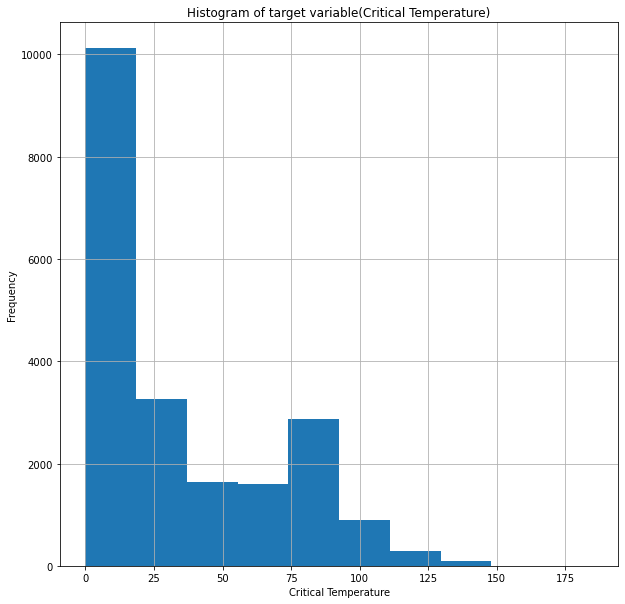

In [65]:
# Histogram of the target variable
plt.figure(figsize = (10,10))

plt.hist(y_train_full)

plt.title('Histogram of target variable(Critical Temperature)')
plt.xlabel('Critical Temperature')
plt.ylabel('Frequency')

plt.grid(True)

plt.show()

In [66]:
data.head()

number_of_elements  mean_atomic_mass  wtd_mean_atomic_mass  \
0                   4         88.944468             57.862692   
1                   5         92.729214             58.518416   
2                   4         88.944468             57.885242   
3                   4         88.944468             57.873967   
4                   4         88.944468             57.840143   

   gmean_atomic_mass  wtd_gmean_atomic_mass  entropy_atomic_mass  \
0          66.361592              36.116612             1.181795   
1          73.132787              36.396602             1.449309   
2          66.361592              36.122509             1.181795   
3          66.361592              36.119560             1.181795   
4          66.361592              36.110716             1.181795   

   wtd_entropy_atomic_mass  range_atomic_mass  wtd_range_atomic_mass  \
0                 1.062396          122.90607              31.794921   
1                 1.057755          122.90607              36.161939   
2                 0.975980          122.90607              35.741099   
3                 1.022291          122.90607              33.768010   
4                 1.129224          122.90607              27.848743   

   std_atomic_mass  ...  wtd_mean_Valence  gmean_Valence  wtd_gmean_Valence  \
0        51.968828  ...          2.257143       2.213364           2.219783   
1        47.094633  ...          2.257143       1.888175           2.210679   
2        51.968828  ...          2.271429       2.213364           2.232679   
3        51.968828  ...          2.264286       2.213364           2.226222   
4        51.968828  ...          2.242857       2.213364           2.206963   

   entropy_Valence  wtd_entropy_Valence  range_Valence  wtd_range_Valence  \
0         1.368922             1.066221              1           1.085714   
1         1.557113             1.047221              2           1.128571   
2         1.368922             1.029175              1           1.114286   
3         1.368922             1.048834              1           1.100000   
4         1.368922             1.096052              1           1.057143   

   std_Valence  wtd_std_Valence  critical_temp  
0     0.433013         0.437059           29.0  
1     0.632456         0.468606           26.0  
2     0.433013         0.444697           19.0  
3     0.433013         0.440952           22.0  
4     0.433013         0.428809           23.0  

[5 rows x 82 columns]

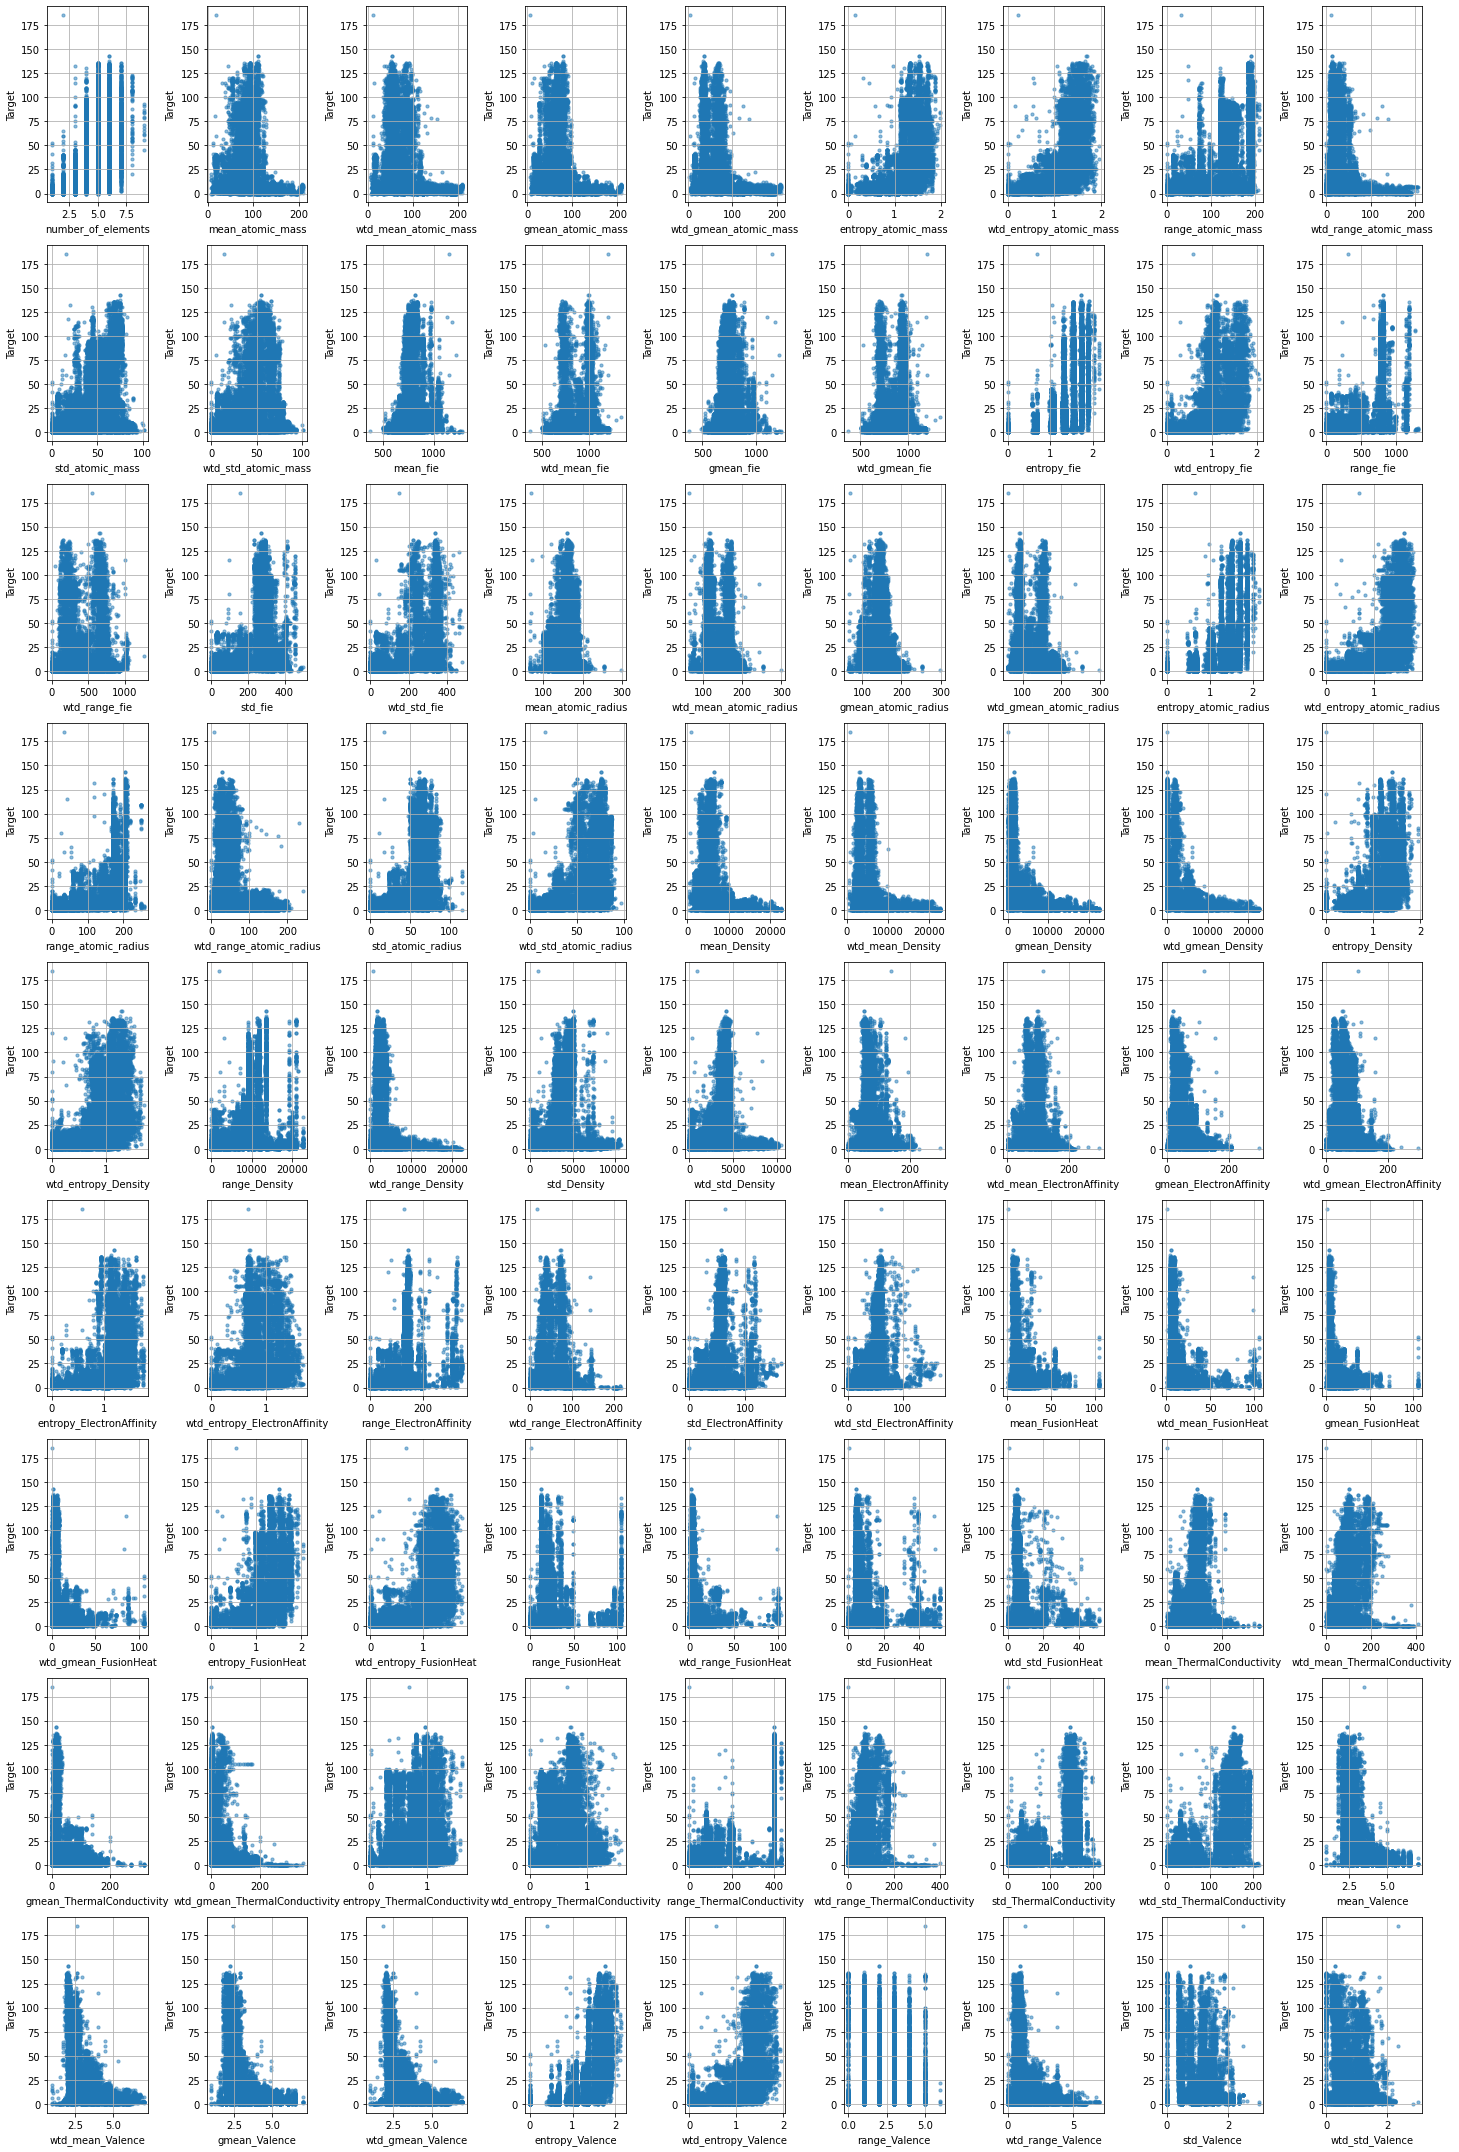

In [79]:
features = data.columns

import matplotlib.pyplot as plt
import numpy as np



# Create a 9x9 subplot grid
fig, axs = plt.subplots(9, 9, figsize=(20, 30))


# Flatten the axis array for easy iteration
axs = axs.flatten()

# Loop through each feature to create scatter plots
for i in range(X_train_full.shape[1]):
    axs[i].scatter(X_train_full[:, i], y_train_full, alpha=0.5, s=10)
    axs[i].set_xlabel(f'{features[i]}')
    axs[i].set_ylabel('Target')
    axs[i].grid(True)
    
plt.tight_layout()
plt.show()


/var/folders/xn/gbft823x5mx4sjzwb1jd4c440000gn/T/ipykernel_7148/1339455889.py:11: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


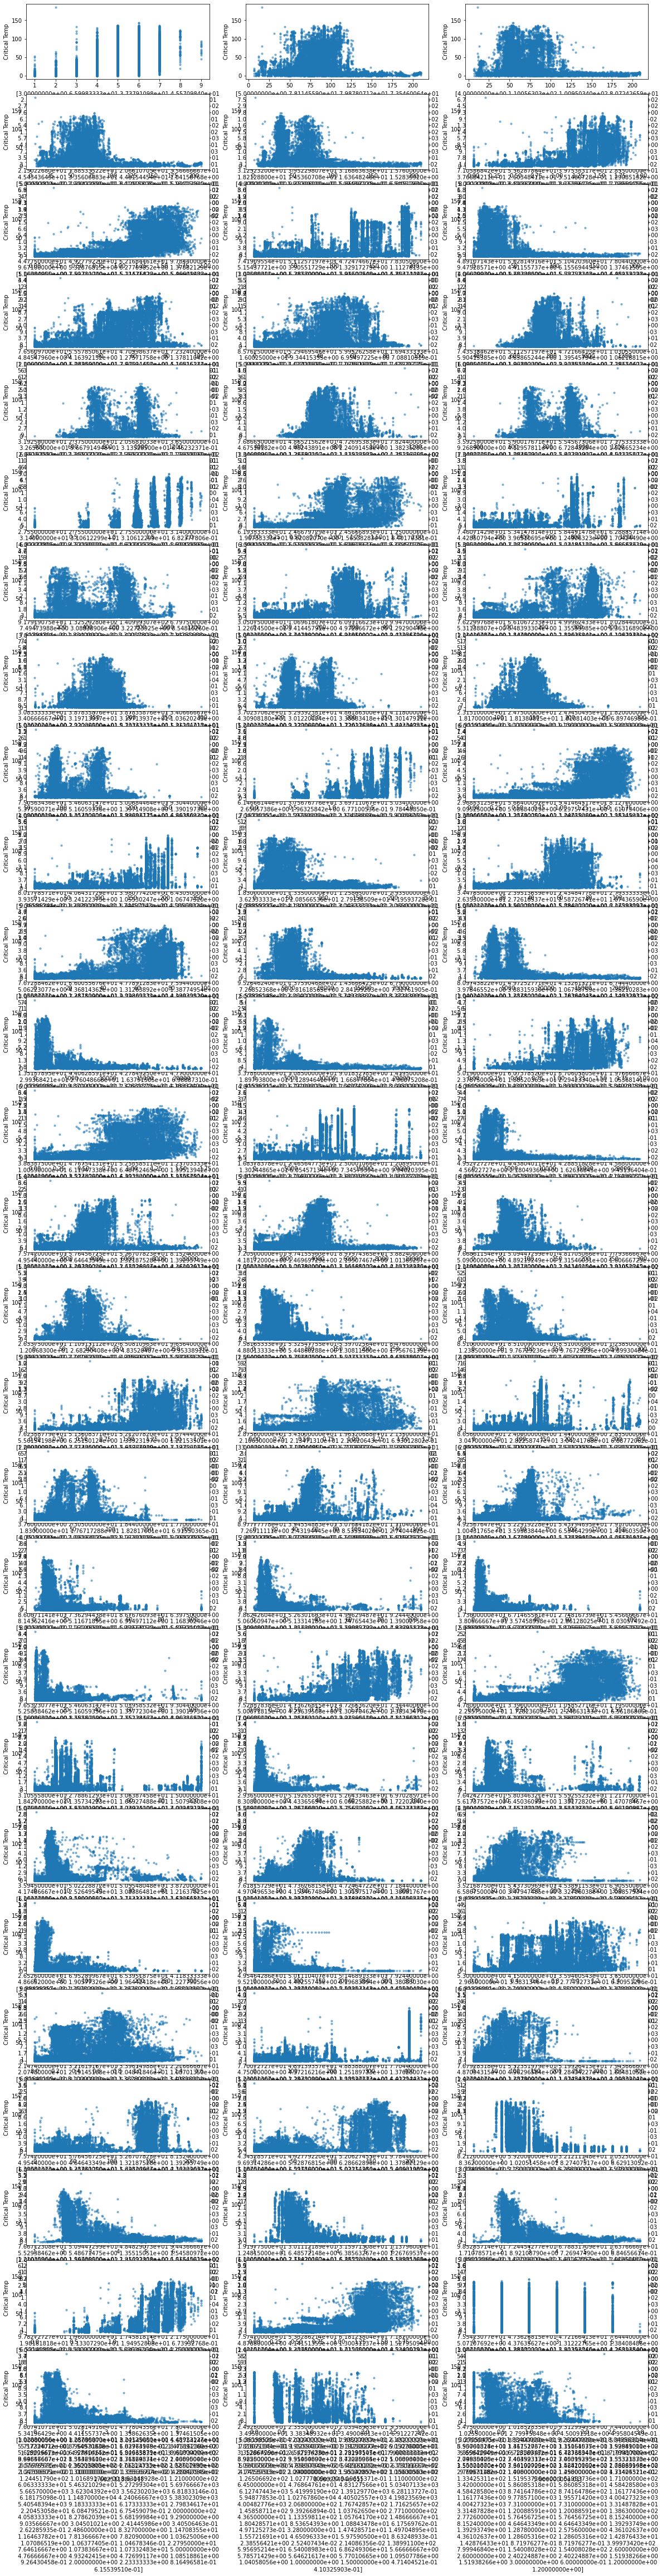

In [18]:
# Scatter plots of the target variable vs. features
plt.figure(figsize = (20,80))


for i, feature in enumerate(X_train_full[:81]):
    plt.subplot(27,3, i+1)
    plt.scatter(X_train_full[:,i], y_train_full, alpha = 0.5, s = 10)
    plt.xlabel(feature)
    plt.ylabel("Critical Temp")

plt.tight_layout()
plt.show()

In [283]:
# Normalize

def normalize(data):
    mean = np.mean(data, axis = 0)
    std = np.std(data, axis = 0)
    normalized_data = (data - mean) / std
    return normalized_data, mean, std

X_train_full_normalized , mean_before, std_before  = normalize(X_train_full)

print(f'Mean Before Normalization : {mean_before[:5]}')
print(f'Standard Variation Before Normalization: {std_before[:5]}\n')


mean_after = np.mean(X_train_full_normalized, axis =0)
std_after = np.std(X_train_full_normalized, axis = 0)

print(f'Mean after Normalization : {mean_after[:5].astype(int)}')
print(f'Stand Variation after Normalization: {std_after[:5]}')

Mean Before Normalization : [ 4.11221885 87.60808137 73.0498836  71.34256083 58.60335661]
Standard Variation Before Normalization: [ 1.43960483 29.70299734 33.56235885 31.0755541  36.73208566]

Mean after Normalization : [0 0 0 0 0]
Stand Variation after Normalization: [1. 1. 1. 1. 1.]


Which material properties may be useful for predicting superconductivity? What other observations can you make?

 YOUR ANSWER HERE

## Task 2:  Implement your own OLS estimator

We want to use linear regression to predict the critical temperature. Implement the ordinary least squares estimator without regularization 'by hand':

$w = (X^TX)^{-1}X^Ty$

To make life a bit easier, we provide a function that can be used to plot regression results. In addition it computes the mean squared error and the squared correlation between the true and predicted values. 

In [251]:
def plot_regression_results(y_test, y_pred, weights):
    '''Produces three plots to analyze the results of linear regression:
        -True vs predicted
        -Raw residual histogram
        -Weight histogram

    Inputs:
        y_test: (n_observations,) numpy array with true values
        y_pred: (n_observations,) numpy array with predicted values
        weights: (n_weights) numpy array with regression weights'''

    print('MSE: ', mean_squared_error(y_test, y_pred))
    print('r^2: ', r2_score(y_test, y_pred))

    fig, ax = plt.subplots(1, 3, figsize=(9, 3))
    # predicted vs true
    ax[0].scatter(y_test, y_pred, s=2)
    ax[0].set_title('True vs. Predicted')
    ax[0].set_xlabel('True %s' % (target_clm))
    ax[0].set_ylabel('Predicted %s' % (target_clm))

    # residuals
    error = np.squeeze(np.array(y_test)) - np.squeeze(np.array(y_pred))
    ax[1].hist(np.array(error), bins=30)
    ax[1].set_title('Raw residuals')
    ax[1].set_xlabel('(true-predicted)')

    # weight histogram
    ax[2].hist(weights, bins=30)
    ax[2].set_title('weight histogram')

    plt.tight_layout()

As an example, we here show you how to use this function with random data. 

MSE:  23059.557446821764
r^2:  -17.41023964366324


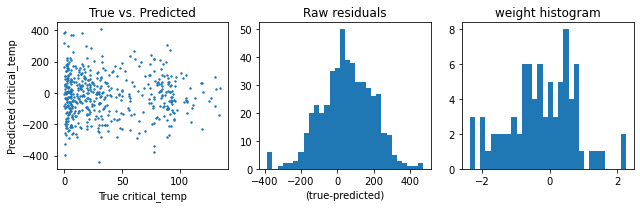

In [252]:
# weights is a vector of length 82: the first value is the intercept (beta0), then 81 coefficients
weights = np.random.randn(82)

# Model predictions on the test set
y_pred_testing = np.random.randn(y_test.size) * np.max(y_test)

plot_regression_results(y_test, y_pred_testing, weights)

Implement OLS linear regression yourself. Use `X_train` and `y_train` for estimating the weights and compute the MSE and $r^2$ from `X_test`. When you call our plotting function with the regression result, you should get mean squared error of 707.8.

In [253]:
def ols_regression(X_test, X_train, y_train):
    '''Computes OLS weights for linear regression without regularization on the training set and
       returns weights and testset predictions.

       Inputs:
         X_test: (n_observations, 81), numpy array with predictor values of the test set
         X_train: (n_observations, 81), numpy array with predictor values of the training set
         y_train: (n_observations,) numpy array with true target values for the training set

       Outputs:
         weights: The weight vector for the regerssion model including the offset
         y_pred: The predictions on the TEST set

       Note:
         Both the training and the test set need to be appended manually by a columns of 1s to add
         an offset term to the linear regression model.
    '''
    
    # ---------------- INSERT CODE ----------------------
    
    #append the column of ones to X_train and X_test
    X_train = np.hstack((np.ones((X_train.shape[0],1)),X_train))
    X_test = np.hstack((np.ones((X_test.shape[0],1)), X_test))
    
    
    #compute the weights using OLS formula
    X_train_transpose = np.transpose(X_train)
    weights = np.linalg.inv(X_train_transpose.dot(X_train)).dot(X_train_transpose).dot(y_train)
    
    #compute prediction on X_test
    y_pred = X_test.dot(weights)
    
    
    # ---------------- END CODE -------------------------

    return weights, y_pred



In [254]:
weights_OLS, y_pred_OLS = ols_regression(X_test, X_train, y_train)

MSE:  599.7397625945957
r^2:  0.5211810643520391


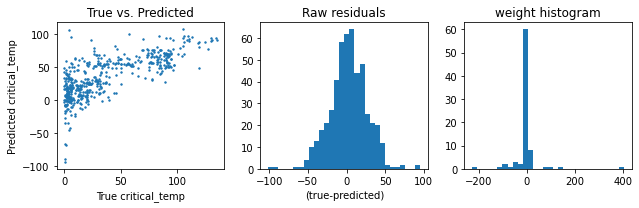

In [255]:
# Plots of the results
plot_regression_results(y_test, y_pred_OLS, weights_OLS)

What do you observe? Is the linear regression model good?

- Taking both the MSE and r^2 values into account, our linear regression model does not perform well. The high MSE suggests that the model's predictions are not consistently accurate, while the moderate value indicates that the model captures only a portion of the variance in the target variable.

## Task 3: Compare your implementation to sklearn

Now, familiarize yourself with the sklearn library. In the section on linear models:

https://scikit-learn.org/stable/modules/classes.html#module-sklearn.linear_model

you will find `sklearn.linear_model.LinearRegression`, the `sklearn` implementation of the OLS estimator. Use this sklearn class to implement OLS linear regression. Again obtain estimates of the weights on `X_train` and `y_train` and compute the MSE and $r^2$ on `X_test`.


In [256]:
def sklearn_regression(X_test, X_train, y_train):
    '''Computes OLS weights for linear regression without regularization using the sklearn library on the training set and
       returns weights and testset predictions.

       Inputs:
         X_test: (n_observations, 81), numpy array with predictor values of the test set
         X_train: (n_observations, 81), numpy array with predictor values of the training set
         y_train: (n_observations,) numpy array with true target values for the training set

       Outputs:
         weights: The weight vector for the regerssion model including the offset
         y_pred: The predictions on the TEST set

       Note:
         The sklearn library automatically takes care of adding a column for the offset.
    '''
    

    # ---------------- INSERT CODE ----------------------
    from sklearn.linear_model import LinearRegression
    lr = LinearRegression()
    lr.fit(X_train, y_train)
    
    
    # Get coefficients and intercept
    weights = np.hstack((np.reshape(lr.intercept_,(1,1)), lr.coef_))
    
    #predict on test data
    y_pred = lr.predict(X_test)

    # ---------------- END CODE -------------------------

    return weights, y_pred

MSE:  599.7397626177594
r^2:  0.5211810643335458


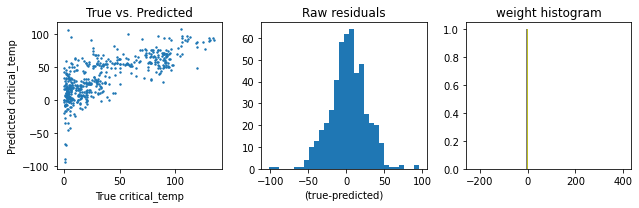

In [257]:
weights_sklearn_regression, y_pred_sklearn_regression = sklearn_regression(X_test, X_train, y_train)

plot_regression_results(y_test, y_pred_sklearn_regression, weights_sklearn_regression)

If you implemented everything correctly, the MSE is again 707.8.

Fit the model using the larger training set, `X_train_full` and `y_train_full`, and again evaluate on `X_test`.

MSE:  329.86070104103686
r^2:  0.7366465263179088


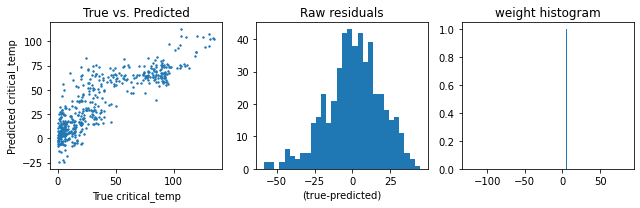

In [258]:
weights_sklearn_regression_full, y_pred_sklearn_regression_full = sklearn_regression(X_test, X_train_full, y_train_full)
plot_regression_results(y_test, y_pred_sklearn_regression_full, weights_sklearn_regression_full)

 How does test set performance change? What else changes?

- Better Test Set Performance: The model's performance on the test set has improved with a lower MSE and a higher r^2 ,indicating better predictive accuracy and model fit.

- Overall Model Improvement: Training the model on a larger dataset has led to a more robust and effective model, capturing the underlying relationships in the data more accurately.

## Task 4: Regularization with ridge regression

We will now explore how a penalty term on the weights can improve the prediction quality for finite data sets. Implement the analytical solution of ridge regression 

$w = (X^TX + \alpha I_D)^{-1}X^Ty$


as a function that can take different values of $\alpha$, the regularization strength, as an input. In the lecture, this parameter was called $\lambda$, but this is a reserved keyword in Python.

In [259]:
def ridge_regression(X_test, X_train, y_train, alpha):
    '''Computes OLS weights for regularized linear regression with regularization strength alpha
       on the training set and returns weights and testset predictions.

       Inputs:
         X_test: (n_observations, 81), numpy array with predictor values of the test set
         X_train: (n_observations, 81), numpy array with predictor values of the training set
         y_train: (n_observations,) numpy array with true target values for the training set
         alpha: scalar, regularization strength

       Outputs:
         weights: The weight vector for the regression model including the offset
         y_pred: The predictions on the TEST set

       Note:
         Both the training and the test set need to be appended manually by a columns of 1s to add
         an offset term to the linear regression model.
    '''

    # ---------------- INSERT CODE ----------------------
    #append the column of ones to X_train and X_test
    X_train = np.hstack((np.ones((X_train.shape[0],1)),X_train))
    X_test = np.hstack((np.ones((X_test.shape[0],1)), X_test))
    
    
    # Compute the weights using Ridge Regression formula
    n_features = X_train.shape[1]
    I = np.eye(n_features)  # Identity matrix
    X_train_transpose = np.transpose(X_train)
    
    weights = np.linalg.inv(X_train_transpose.dot(X_train) + alpha * I).dot(X_train_transpose).dot(y_train)
    
    #compute prediction on X_test
    y_pred = X_test.dot(weights)
    

    # ---------------- END CODE -------------------------

    return weights, y_pred

Run the ridge regression on `X_train` with an alpha value of 10 and plot the obtained weights.

MSE:  429.73785000135643
r^2:  0.6569068239612721


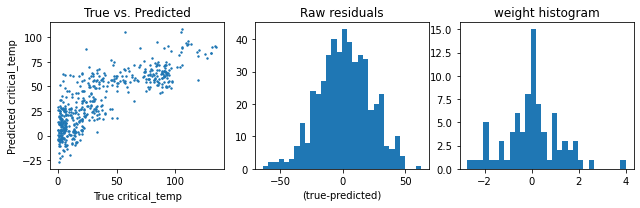

In [260]:
# Run ridge regression with alpha=10
weights, y_pred = ridge_regression(X_test, X_train, y_train, 10)

# Plot regression results
plot_regression_results(y_test, y_pred, weights,)

Now test a range of log-spaced $\alpha\text{s}$ (~10-20), which cover several orders of magnitude, e.g. from 10^-7 to 10^7. 

* For each $\alpha$, you will get one model with one set of weights. 
* For each model, compute the error on the test set. 

Store both the errors and weights of all models for later use. You can use the function `mean_squared_error` from sklearn (imported above) to compute the MSE.


In [261]:
alphas = np.logspace(-7, 7, 20)

# ---------------- INSERT CODE ----------------------
errors = []
all_weights = []

for alpha in alphas:
    # Compute weights and predictions using ridge regression
    weights, y_pred = ridge_regression(X_test, X_train, y_train, alpha)
    
    # Compute MSE
    mse = mean_squared_error(y_test, y_pred)
    
    
    # Store MSE and weights
    errors.append(mse)
    all_weights.append(weights)

# ---------------- END CODE -------------------------

In [262]:
alphas.shape

(20,)

In [263]:
np.array(all_weights).shape

(20, 82, 1)

Make a single plot that shows for each coefficient how it changes with $\alpha$, i.e. one line per coefficient. Also think about which scale is appropriate for your $\alpha$-axis. You can set this using `plt.xscale(...)`.

/var/folders/xn/gbft823x5mx4sjzwb1jd4c440000gn/T/ipykernel_1457/3835183584.py:28: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


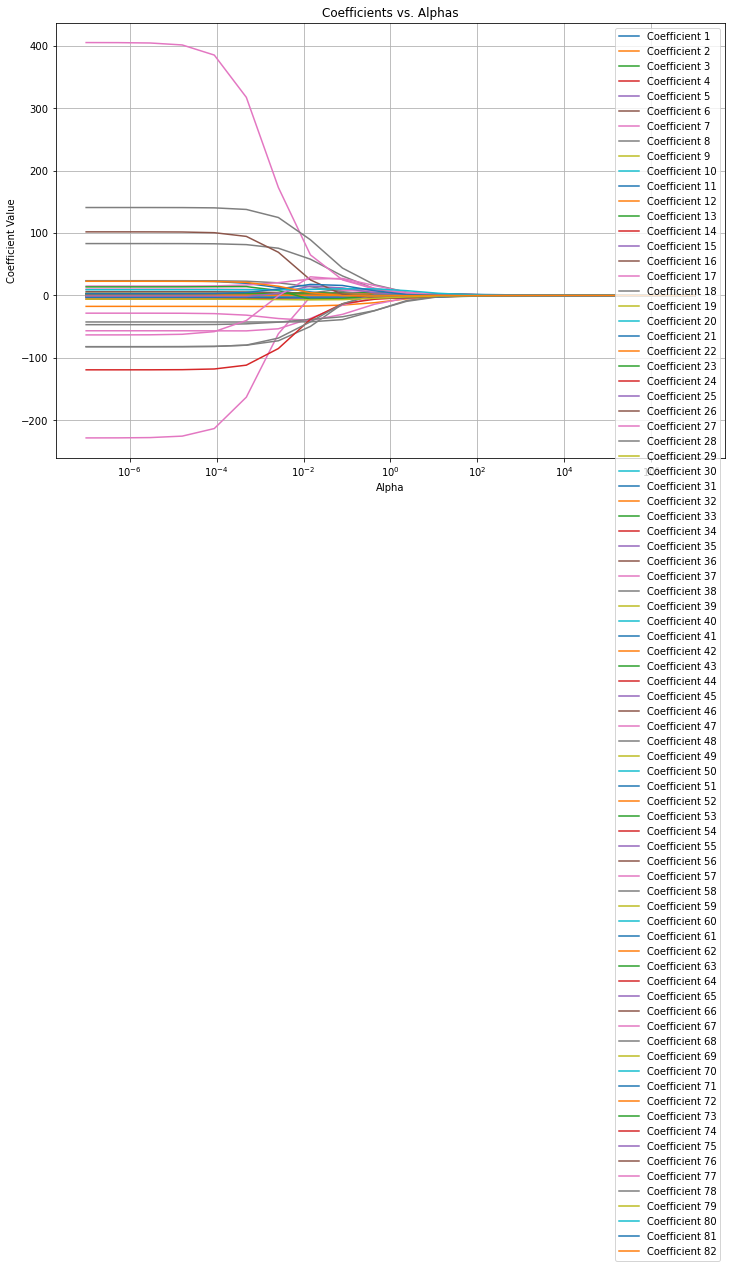

In [264]:
# Plot of coefficients vs. alphas

def plot_coefficients_vs_alphas(all_weights, alphas):
    
    # Extract coefficients from all_weights
    coefficients = np.array(all_weights).squeeze().T  # Transpose to have one coefficient per row
    
    # Create the plot
    plt.figure(figsize=(12, 8))
    
    # Plot each coefficient
    for i in range(coefficients.shape[0]):
        plt.plot(alphas, coefficients[i,:], label=f'Coefficient {i+1}')

    # Set plot labels and title
    plt.xlabel('Alpha')
    plt.ylabel('Coefficient Value')
    plt.title('Coefficients vs. Alphas')
    
    # Set log scale for alpha axis
    plt.xscale('log')
    
    # Add legend
    plt.legend()
    
    # Show plot
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Plot coefficients vs. alphas
plot_coefficients_vs_alphas(all_weights, alphas)

Why are the values of the weights largest on the left? Do they all change monotonically? 

- The values of the weights are largest on the left because the alpha values are smallest on the left. In ridge regression, as the regularization strength (alpha) increases, the penalty on the magnitude of the coefficients also increases. This means that as alpha increases, the model is more constrained, leading to smaller coefficient values
- Coefficients generally decrease in magnitude as alpha increases, but they might not always be strictly monotonically decreasing.


Plot how the performance (i.e. the error) changes as a function of $\alpha$. As a sanity check, the MSE value for very small $\alpha$ should be close to the test-set MSE of the unregularized solution, i.e. 708.

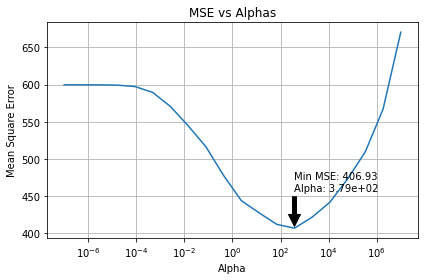

In [265]:
# Plot of MSE  vs. alphas

def plot_mse_vs_error(alphas, mse):
    
    # Find the alpha that gives the minimum MSE
    best_alpha = alphas[np.argmin(errors)]
    min_mse = min(errors)

    plt.plot(alphas,errors, linestyle = '-')
    plt.xlabel('Alpha')
    plt.ylabel('Mean Square Error')
    plt.title('MSE vs Alphas')
    plt.xscale('log')
    plt.grid(True)

    # Annotate the minimum MSE point
    plt.annotate(f'Min MSE: {min_mse:.2f}\nAlpha: {best_alpha:.2e}',
                 xy=(best_alpha, min_mse),
                 xytext=(best_alpha, min_mse + 50),  # Position of the text
                 arrowprops=dict(facecolor='black', shrink=0.05),  # Arrow properties
                 )

    plt.tight_layout()
    plt.show()

plot_mse_vs_error(alphas, mse)

Which value of $\alpha$ gives the minimum MSE? Is it better than the unregularized model? Why should the curve reach ~700 on the left?

- 10^2 gives the minumum MSE. Yes it performs better than the unregularized model. 
- The curve should reach around 599 on the left because for very small α, the ridge regression model approaches the unregularized linear regression model. As α decreases, the penalty due to regularization decreases, and the ridge regression model becomes similar to the OLS (Ordinary Least Squares) model. Thus, the MSE should approach the MSE of the unregularized OLS model, which is around 599 in this case.

Now implement the same model using sklearn. Use the `linear_model.Ridge` object to do so.


In [285]:
from sklearn.linear_model import Ridge


def ridge_regression_sklearn(X_test, X_train, y_train, alpha):
    '''Computes OLS weights for regularized linear regression with regularization strength alpha using the sklearn
       library on the training set and returns weights and testset predictions.

       Inputs:
         X_test: (n_observations, 81), numpy array with predictor values of the test set
         X_train: (n_observations, 81), numpy array with predictor values of the training set
         y_train: (n_observations,) numpy array with true target values for the training set
         alpha: scalar, regularization strength

       Outputs:
         weights: The weight vector for the regerssion model including the offset
         y_pred: The predictions on the TEST set

       Note:
         The sklearn library automatically takes care of adding a column for the offset.
    '''

    # ---------------- INSERT CODE ----------------------
    
    #Initialize Ridge regression model
    ridge = Ridge(alpha=alpha)

    # Fit the model on the training data
    ridge.fit(X_train, y_train)
    
    
    #get coefficients and intercepts
    weights = np.hstack((np.reshape(ridge.intercept_, (1,1)), ridge.coef_))

    # Predict on test data
    y_pred = ridge.predict(X_test)

    # ---------------- END CODE -------------------------

    return y, y_pred


errors = []
all_weights = []

for alpha in alphas:
    # Compute weights and predictions using ridge regression
    weights, y_pred = ridge_regression_sklearn(X_test, X_train, y_train, alpha)
    
    # Compute MSE
    mse_sklearn_ridge = mean_squared_error(y_test, y_pred)
    
    
    # Store MSE and weights
    errors.append(mse_sklearn_ridge)
    all_weights.append(weights)

This time, only plot how the performance changes as a function of $\alpha$. 

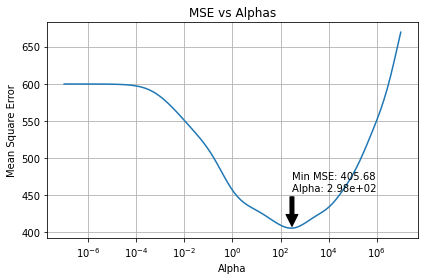

In [286]:
# Plot of MSE  vs. alphas
plot_mse_vs_error(alphas, errors)

Note: Don't worry if the curve is not exactly identical to the one you got above. The loss function we wrote down in the lecture  has $\alpha$ defined a bit differently compared to sklearn. However, qualitatively it should look the same.

## Task 5: Cross-validation

Until now, we always estimated the error on the test set directly. However, we typically do not want to tune hyperparameters of our inference algorithms like $\alpha$ on the test set, as this may lead to overfitting. Therefore, we tune them on the training set using cross-validation. As discussed in the lecture, the training data is here split in `n_folds`-ways, where each of the folds serves as a held-out dataset in turn and the model is always trained on the remaining data. Implement a function that performs cross-validation for the ridge regression parameter $\alpha$. You can reuse functions written above.

In [287]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=10, shuffle=True, random_state = 2)

for train_index, val_index in kf.split(X_train):
    print(f"Train indices: {train_index}")
    print(f"Validation indices: {val_index}")
    print("-" * 40)



Train indices: [  0   1   4   5   6   7   8   9  11  15  16  17  18  19  20  21  22  23
  24  25  26  27  28  30  31  32  33  34  36  37  38  39  40  41  42  43
  45  46  47  48  49  50  51  52  53  55  56  57  58  59  60  61  62  63
  64  65  66  67  68  69  70  71  72  73  74  75  76  77  78  79  80  81
  82  83  84  86  87  88  89  90  91  93  94  95  96  97  98  99 100 101
 102 103 104 105 106 107 108 109 110 111 114 116 117 118 119 120 121 122
 123 124 125 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141
 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159
 160 161 162 163 164 165 166 167 168 169 170 171 172 173 175 176 177 178
 179 180 181 183 184 185 186 187 188 189 190 191 192 194 195 196 197 198]
Validation indices: [  2   3  10  12  13  14  29  35  44  54  85  92 112 113 115 126 174 182
 193 199]
----------------------------------------
Train indices: [  0   1   2   3   4   5   7   8  10  11  12  13  14  15  16  17  18  19
  20  21  22  24  26  

In [288]:
from sklearn.model_selection import KFold
def ridgeCV(X, y, n_folds, alphas):
    '''Runs a n_fold-crossvalidation over the ridge regression parameter alpha.
       The function should train the linear regression model for each fold on all values of alpha.

      Inputs:
        X: (n_obs, n_features) numpy array - predictor
        y: (n_obs,) numpy array - target
        n_folds: integer - number of CV folds
        alphas: (n_parameters,) - regularization strength parameters to CV over

      Outputs:
        cv_results_mse: (n_folds, len(alphas)) numpy array, MSE for each cross-validation fold

      Note:
        Fix the seed for reproducibility.
    '''

    cv_results_mse = np.zeros((n_folds, len(alphas)))
    np.random.seed(seed=2)

    # ---------------- INSERT CODE ---------------------- 
    kf = KFold(n_splits = n_folds, shuffle = True, random_state = 2)
    
    for fold, (train_index, val_index) in enumerate(kf.split(X)):
        X_train, X_val = X[train_index], X[val_index]
        y_train, y_val = y[train_index], y[val_index]
        
        for i, alpha in enumerate(alphas):
            #fit ridge regressioin model
            ridge = Ridge(alpha = alpha)
            ridge.fit(X_train, y_train)
            
            #predict on validation set
            y_pred = ridge.predict(X_val)
            
            #calculate mse and store
            mse = mean_squared_error(y_val, y_pred)
            cv_results_mse[fold, i] = mse
            
    # ---------------- END CODE -------------------------

    return cv_results_mse

Now we run 10-fold cross-validation using the training data of a range of $\alpha$s.

In [289]:
alphas = np.logspace(-7, 7, 100)
mse_cv = ridgeCV(X_train, y_train, n_folds=10, alphas=alphas)

We plot the MSE trace for each fold separately:

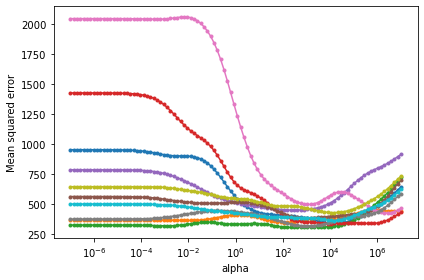

In [290]:
plt.plot(alphas, mse_cv.T, '.-')
plt.xscale('log')
plt.xlabel('alpha')
plt.ylabel('Mean squared error')
plt.tight_layout()

We also plot the average across folds:

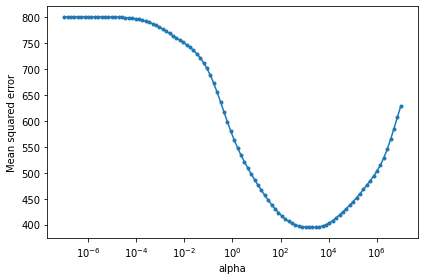

In [291]:
plt.figure(figsize=(6, 4))
plt.plot(alphas, np.mean(mse_cv, axis=0), '.-')
plt.xscale('log')
plt.xlabel('alpha')
plt.ylabel('Mean squared error')
plt.tight_layout()

In [273]:
#best test_set MSE 
print("Best Test Set MSE: ", min(errors))

mse_flatten = mse_cv.flatten()

print("Best Cross_validation MSE",min(min_flatten))

Best Test Set MSE:  406.0886912143967
Best Cross_validation MSE 307.8946099228717


What is the optimal $\alpha$? Is it similar to the one found on the test set? Do the cross-validation MSE and the test-set MSE match well or differ strongly?

- From above two graphs, we can see that optimal 𝛼 is between 10^2 and 10^4 and is similar to the one found on the test set.
- Cross validation MSE and test_set MSE are in same range. Cross validation MSE is slightly better than test_set MSE

We will now run cross-validation on the full training data. This will take a moment, depending on the speed of your computer. Afterwards, we will again plot the mean CV curves for the full data set (blue) and the small data set (orange).

In [274]:
alphas = np.logspace(-7, 7, 100)
mse_cv_full = ridgeCV(X_train_full, y_train_full, n_folds=10, alphas=alphas)

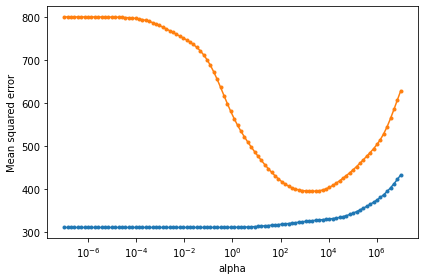

In [275]:
plt.figure(figsize=(6, 4))
plt.plot(alphas, np.mean(mse_cv_full, axis=0), '.-')
plt.plot(alphas, np.mean(mse_cv, axis=0), '.-')
plt.xscale('log')
plt.xlabel('alpha')
plt.ylabel('Mean squared error')
plt.tight_layout()

We zoom in on the blue curve to the very left:

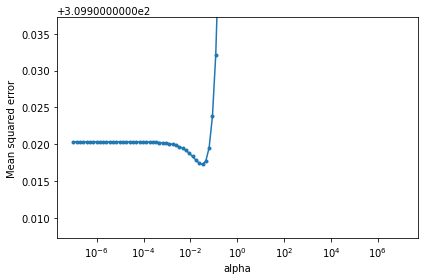

In [276]:
plt.figure(figsize=(6, 4))
plt.plot(alphas, np.mean(mse_cv_full, axis=0), '.-')
plt.xscale('log')
minValue = np.min(np.mean(mse_cv_full, axis=0))
plt.ylim([minValue-.01, minValue+.02])
plt.xlabel('alpha')
plt.ylabel('Mean squared error')
plt.tight_layout()

Why does the CV curve on the full data set look so different? What is the optimal value of $\alpha$ and why is it so much smaller than on the small training set?

- Low Bias, High Variance: With a larger dataset, the model has more data to learn from and can capture more complex patterns. Therefore, even without regularization (small alpha), the model performs relatively well.

- Optimal Alpha: The optimal alpha for the large dataset is likely smaller because the model doesn't need as much regularization to prevent overfitting. The model can afford to be more complex without fitting the noise in the data.